In [25]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [27]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [28]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [29]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [30]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [31]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [32]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [33]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 5s 140ms/step - loss: 0.0330 - val_loss: 0.0020
Epoch 2/100
19/19 [==============================] - 1s 68ms/step - loss: 0.0041 - val_loss: 2.4323e-04
Epoch 3/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0011 - val_loss: 1.6718e-04
Epoch 4/100
19/19 [==============================] - 1s 59ms/step - loss: 6.5484e-04 - val_loss: 1.6710e-04
Epoch 5/100
19/19 [==============================] - 1s 57ms/step - loss: 5.6525e-04 - val_loss: 1.4391e-04
Epoch 6/100
19/19 [==============================] - 1s 57ms/step - loss: 5.4443e-04 - val_loss: 1.4572e-04
Epoch 7/100
19/19 [==============================] - 1s 59ms/step - loss: 5.1243e-04 - val_loss: 1.3736e-04
Epoch 8/100
19/19 [==============================] - 1s 63ms/step - loss: 4.9304e-04 - val_loss: 1.3817e-04
Epoch 9/100
19/19 [==============================] - 1s 58ms/step - loss: 4.8709e-04 - val_loss: 1.3665e-04
Epoch 10/100
19/19 [=======================

In [35]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 12ms/step


In [36]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [37]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 26979.764674566362


In [38]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99917535658354
Testing MAE: 26832.511242604403


In [39]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.23314231634140015], [0.23506735265254974], [0.2372787445783615], [0.23962438106536865], [0.24204933643341064], [0.2445315420627594], [0.24706001579761505], [0.24962754547595978], [0.2522291839122772], [0.25486060976982117], [0.25751832127571106], [0.26019957661628723], [0.2629017233848572], [0.26562270522117615], [0.2683606743812561], [0.27111396193504333], [0.2738812267780304], [0.27666106820106506], [0.27945244312286377], [0.28225427865982056], [0.285065621137619], [0.2878856360912323], [0.2907133996486664], [0.29354822635650635], [0.29638931155204773], [0.299235999584198], [0.30208736658096313], [0.30494293570518494], [0.3078019320964813], [0.3106636703014374], [0.31352758407592773], [0.31639283895492554], [0.3192589282989502], [0.3221251964569092], [0.3249909281730652], [0.3278554677963257], [0.33071812987327576], [0.3335782289505005], [0.3364351987838745], [0.33928826451301575], [0.3421369194984436], [0.34498026967048645], [0.3478180170059204], [0.35064905881881714], [0.353473

In [40]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27948.77857422],
       [28125.121333  ],
       [28327.69566923],
       [28542.56746505],
       [28764.70525905],
       [28992.0874575 ],
       [29223.70804114],
       [29458.90634057],
       [29697.22916937],
       [29938.2806719 ],
       [30181.74006863],
       [30427.35619598],
       [30674.8860805 ],
       [30924.14134952],
       [31174.95274063],
       [31427.16737166],
       [31680.66239088],
       [31935.30948645],
       [32191.01310703],
       [32447.6749712 ],
       [32705.20771775],
       [32963.53490557],
       [33222.57190348],
       [33482.25592057],
       [33742.51324579],
       [34003.28381831],
       [34264.48300691],
       [34526.06713098],
       [34787.9652095 ],
       [35050.1144516 ],
       [35312.46298652],
       [35574.93437318],
       [35837.48220093],
       [36100.04640892],
       [36362.5614762 ],
       [36624.96734194],
       [36887.20121523],
       [37149.20030519],
       [37410.91274108],
       [37672.26754189],


In [41]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [42]:
print(y_pred_with_test_data.shape)
test_data.shape

(320,)


(320, 1)

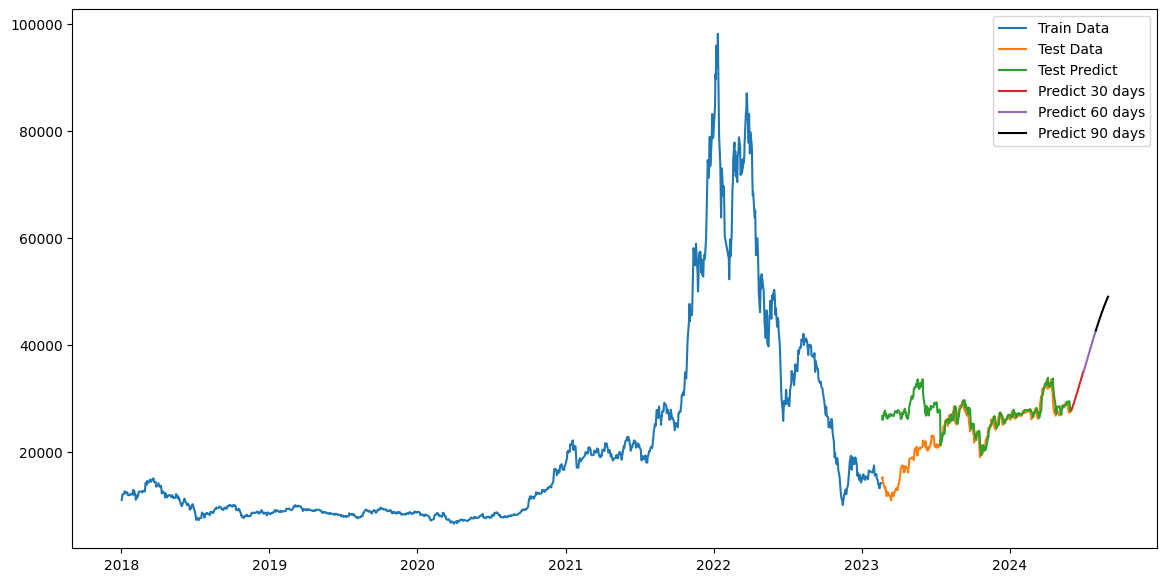

In [45]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()